### Telemetry Hello World

This is a very a brief introduction to Spark and Telemetry in Python. You should have a look at the [tutorial](https://gist.github.com/vitillo/25a20b7c8685c0c82422) in Scala and the associated [talk](http://www.slideshare.net/RobertoAgostinoVitil/spark-meets-telemetry) if you are interested to learn more about Spark.

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py

from plotly.graph_objs import *
from moztelemetry import get_pings_properties, get_one_ping_per_client
from moztelemetry.dataset import Dataset

%matplotlib inline

Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/histogram-whitelists.json). Assuming all histograms are acceptable.


### Basics

The goal of this example is to plot the startup distribution for each OS. Let's see how many parallel workers we have at our disposal:

In [2]:
sc.defaultParallelism

32

Let's fetch 10% of Telemetry submissions for a given submission date...

In [3]:
Dataset.from_source("telemetry").schema

[u'submissionDate',
 u'sourceName',
 u'sourceVersion',
 u'docType',
 u'appName',
 u'appUpdateChannel',
 u'appVersion',
 u'appBuildId']

In [4]:
pings = Dataset.from_source("telemetry") \
    .where(docType='main') \
    .where(submissionDate="20161101") \
    .where(appUpdateChannel="nightly") \
    .records(sc, sample=0.1)

... and extract only the attributes we need from the Telemetry submissions:

In [5]:
subset = get_pings_properties(pings, ["clientId",
                                      "environment/system/os/name",
                                      "payload/simpleMeasurements/firstPaint"])

Let's filter out submissions with an invalid startup time:

In [6]:
subset = subset.filter(lambda p: p.get("payload/simpleMeasurements/firstPaint", -1) >= 0)

To prevent pseudoreplication, let's consider only a single submission for each client. As this step requires a distributed shuffle, it should always be run only after extracting the attributes of interest with *get_pings_properties*.

In [7]:
subset = get_one_ping_per_client(subset)

Caching is fundamental as it allows for an iterative, real-time development workflow:

In [8]:
cached = subset.cache()

How many pings are we looking at?

In [9]:
cached.count()

7132

Let's group the startup timings by OS:

In [10]:
grouped = cached.map(lambda p: (p["environment/system/os/name"], p["payload/simpleMeasurements/firstPaint"])).groupByKey().collectAsMap()

And finally plot the data:

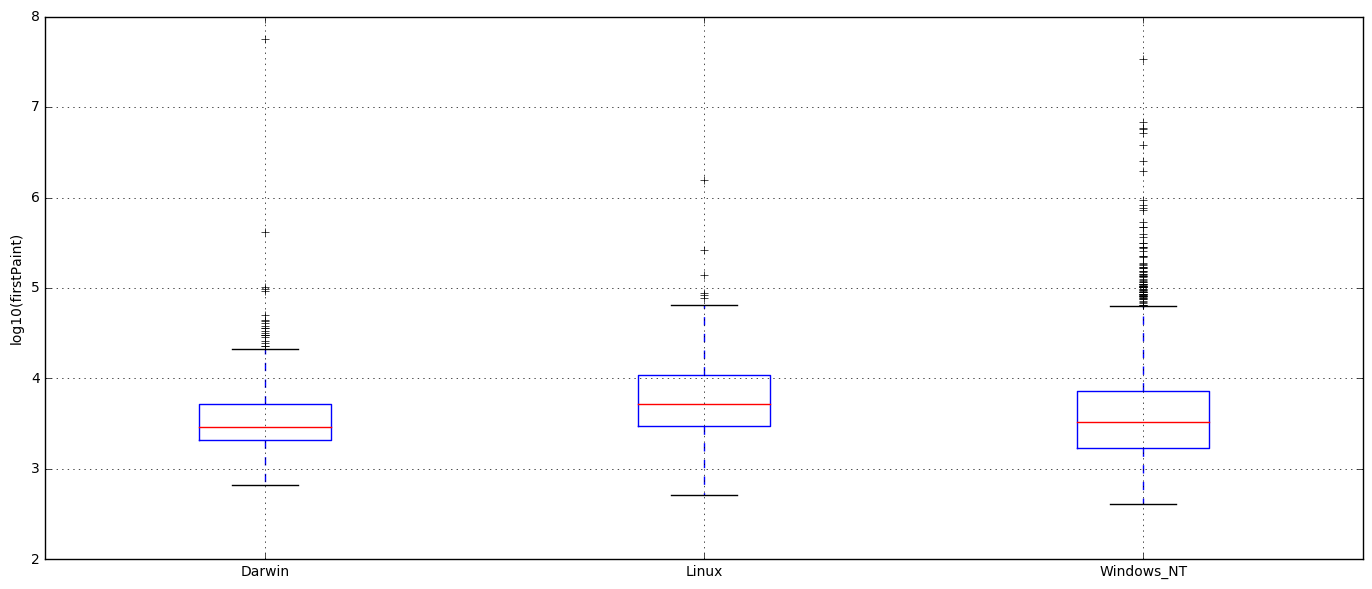

In [11]:
frame = pd.DataFrame({x: np.log10(pd.Series(list(y))) for x, y in grouped.items()})
plt.figure(figsize=(17, 7))
frame.boxplot(return_type="axes")
plt.ylabel("log10(firstPaint)")
plt.show()

You can also create interactive plots with [plotly](https://plot.ly/):

In [12]:
fig = plt.figure(figsize=(18, 7))
frame["Windows_NT"].plot(kind="hist", bins=50)
plt.title("startup distribution for Windows")
plt.ylabel("count")
plt.xlabel("log10(firstPaint)")
py.iplot_mpl(fig, strip_style=True)

### Histograms

Let's extract a histogram from the submissions:

In [13]:
histograms = get_pings_properties(pings, "payload/histograms/GC_MARK_MS", with_processes=True)

The API returns three distinct histograms for each submission:
- a histogram for the parent process (*GC_MARK_MS_parent*)
- an aggregated histogram for the child processes (*GC_MARK_MS_children*)
- the aggregate of the parent and child histograms (*GC_MARK*)

Let's aggregate the histogram over all submissions and plot it:

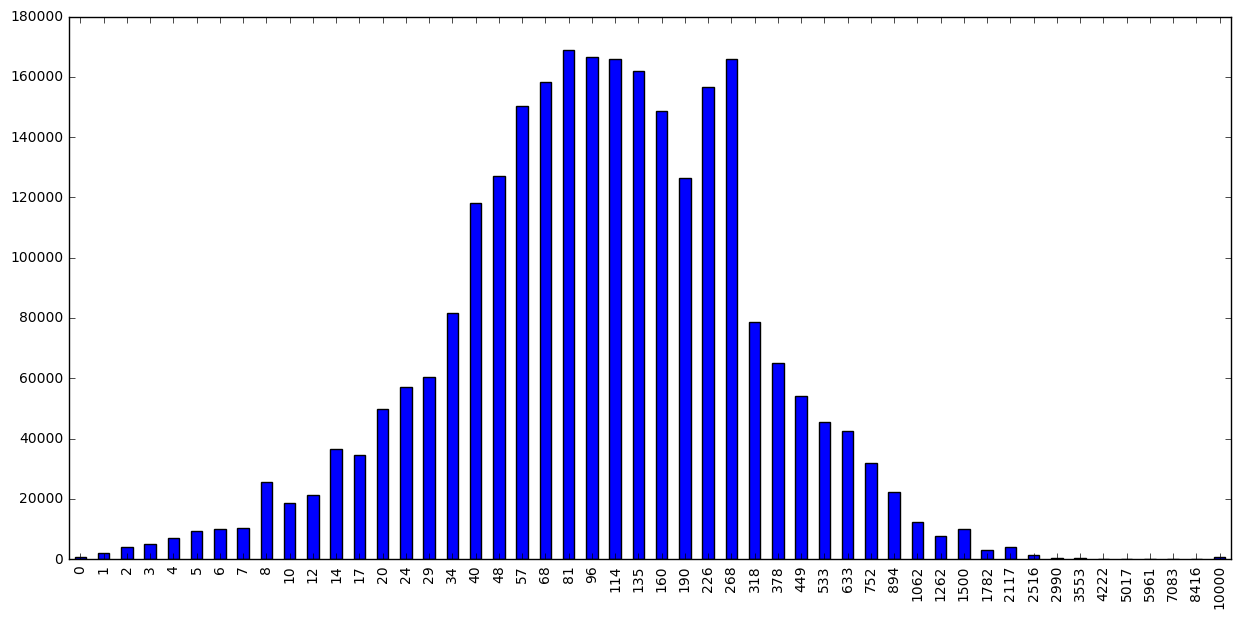

In [14]:
def aggregate_arrays(xs, ys):
    if xs is None:
        return ys
    
    if ys is None:
        return xs
    
    return xs + ys
    
aggregate = histograms.map(lambda p: p["payload/histograms/GC_MARK_MS"]).reduce(aggregate_arrays)
aggregate.plot(kind="bar", figsize=(15, 7))

Keyed histograms follow a similar pattern. To extract a keyed histogram for which we know the key/label we are interested in:

In [15]:
histograms = get_pings_properties(pings, "payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin", with_processes=True)

List all keys/labels for a keyed histogram:

In [16]:
keys = pings.flatMap(lambda p: p["payload"].get("keyedHistograms", {}).get("MISBEHAVING_ADDONS_JANK_LEVEL", {}).keys())
keys = keys.distinct().collect()

In [17]:
keys[:5]

[u'firefox@zenmate.com',
 u'jid1-f3mYMbCpz2AZYl@jetpack',
 u'jid0-SQnwtgW1b8BsMB5PLV5WScEDWOjw@jetpack',
 u'light_plugin_ACF0E80077C511E59DED005056C00008@kaspersky.com',
 u'netvideohunter@netvideohunter.com']

Retrieve the histograms for a set of labels:

In [18]:
properties = map(lambda k: "payload/keyedHistograms/{}/{}".format("MISBEHAVING_ADDONS_JANK_LEVEL", k), keys[:5])

In [19]:
histograms = get_pings_properties(pings, properties, with_processes=True)